In [2]:
"""
First created on October 29 2022
@author: ncaplar@princeton.edu / ncaplar@uw.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. TESTING_FOLDER will be filled during the run with images from the analysis 

3. (OPTIONAL) Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes somewhat large and possibly hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/tigress/ncaplar/PFS/'
############################################################
    
TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'

# create these directories if they do not exist
import os
for i in [PSF_DIRECTORY,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i) 

In [10]:
import sys
sys.path.insert(0, "/home/ncaplar/Code/dev_2ddrp/2d_PSF_code/")
%load_ext autoreload
%autoreload 2

import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
# from Residual_1D_module import * 
from Zernike_Analysis_Module import *
print(f'Zernike_Module.__version__: {Zernike_Module.__version__}')
print('Zernike_Analysis_Module.__version__: '+str(Zernike_Analysis_Module.__version__))


import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import pickle
import logging

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy 
import scipy.misc

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
matplotlib.rcParams["figure.facecolor"] = "white"

# needed for this notebook
import glob



print(f'np.__version__: {np.__version__}')
print(f'scipy.__version__: {scipy.__version__}')
print(f'pd.__version__: {pd.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Zernike_Module.__version__: 0.52
Zernike_Analysis_Module.__version__: 0.26l
np.__version__: 1.20.3
scipy.__version__: 1.8.1
pd.__version__: 1.4.2


In this notebook we will cover the analysis of the result of fitting run. In these runs we try to optimize the residuals between the model and teh data, in order to determine the parameters that best describe the instrument.
During this exercise we will encounter multi-image class that stores all the images created at single position (but different defocuses) together.

Lets us first load the outputs of these fitting runs. As an example, lets look at the run that I did on Tiger, on March 25 2022.

In [4]:
# The names of the files are chain _ + date + Single_P_ + name of the spot + arc line + Swarm1
# Chain denotes that these file are output from Emcee-like type chain
# SingleP - deprecated 
# Swarm1 - deprecated, at some points in the project I did multistage fitting procedure
# so Swarm1 would feed into Swarm2, Swarm3 etc...

date_folder=''
date_files='Mar2522'
ResultsFromTiger_FOLDER='/tigress/ncaplar/Results/'

# let's see which files describing Argon dataset are avaliable
Emcee3_Ar=glob.glob(ResultsFromTiger_FOLDER+date_folder+'/chain'+date_files+'_Single_P_*ArSwarm1.npy', recursive=True)
#Emcee3_Ne=glob.glob(ResultsFromTiger_FOLDER+date_folder+'/chain'+date_files+'_Single_P_*NeSwarm1.npy', recursive=True)
#Emcee3_Kr=glob.glob(ResultsFromTiger_FOLDER+date_folder+'/chain'+date_files+'_Single_P_*KrSwarm1.npy', recursive=True)

# Print out first few inputs
Emcee3_Ar[0:5]

['/tigress/ncaplar/Results/chainMar2522_Single_P_34437186ArSwarm1.npy',
 '/tigress/ncaplar/Results/chainMar2522_Single_P_516771516ArSwarm1.npy',
 '/tigress/ncaplar/Results/chainMar2522_Single_P_516772226ArSwarm1.npy',
 '/tigress/ncaplar/Results/chainMar2522_Single_P_344371146ArSwarm1.npy',
 '/tigress/ncaplar/Results/chainMar2522_Single_P_516772476ArSwarm1.npy']

We see that there is a difference in names! Some of them are `Single_P_34437` files, and some are `Single_P_51677`.
34437 or 51677 corresponds to the visit_id of the first image that goes into analysis. As 10-fiber and 21-fiber configuration were taken separatly, these visit_id indetifiers are also different.

In [6]:
# These dataframes contain the information about all of the spots, separated 
# in different arclines
finalAr=np.load("/tigress/ncaplar/ReducedData/Data_May_25_2021/Dataframes/finalAr_Jul2021",allow_pickle=True)
finalNe=np.load("/tigress/ncaplar/ReducedData/Data_May_25_2021/Dataframes/finalNe_Jul2021",allow_pickle=True)
finalKr=np.load("/tigress/ncaplar/ReducedData/Data_May_25_2021/Dataframes/finalKr_Jul2021",allow_pickle=True)


Lets say we want to look at some of the data that we have fitting. In order to do that we will invoke Zernike_Analysis module. In order to access the module we need to define few parameters.

In [12]:
date='Mar2522'
# Define the number of the spot we wish to analyze
single_number='53'
# eps is the parameter that control the fitting procedure options. Most of the 
# recent runs have used the option 6. We will touch upon this option in the 
# future tutorials
eps=6
# Which arcline we wish to analyze
arc='Ar'

# all of the spots are placed in the same datafame (finalAr for Argon). There 
# are 12 spots in each fiber. 10 fiber configuration goes first, so up to 
# index of 119 we are working with 10 fiber configuraiton. Larger spot numbers
# are coming from 21 configuration. As such we need to switch the `dataset`
# and `obs` value - dentoing from each dataset we are taking the data. 
if arc=='Ar':

    finalArc=finalAr
    if int(single_number)<120:
        dataset=6
        obs=34341+96
    if int(single_number)>=120:
        dataset=8
        obs=51485+16*12

# Same for Neon, but we have only indentified 9 spots per fiber in Neon        
if arc=='Ne':

    finalArc=finalNe
    if int(single_number)<90:
        dataset=6
        obs=27719
    if int(single_number)>=90:
        dataset=8    
        obs=59655+16*12
        
# Same for Krypton, but we have only indentified 4 spot per fiber in Krypton        
if arc=='Kr':

    finalArc=finalKr
    if int(single_number)<40:
        dataset=6
        obs=34561+96
    if int(single_number)>=40:
        dataset=8
        obs=52085+16*12
    
# Extract the wavelength value from the finalArc dataframe
wavelength=float(finalArc.loc[int(single_number)]['wavelength'])
#wavelength=None

# These are predetermined value for defocused that we would likely analyze
# the `m` or `p` denotes minus or plus
# value after m/p denote amount of defocus in mm 
# For instance, m4 - slit has been moved in negative direction 4mm
list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_short_with_focus=['m4','0','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

# Let's verify what is loaded in the finalArc dataframe
finalArc.loc[int(single_number)]

fiber                   401
xc                     1610
yc                     1606
wavelength        763.74286
close                     1
lamp                     Ar
xc_effective           1610
second_offset           0.0
second_ratio            0.0
second2_offset          0.0
second2_ratio           0.0
Name: 53, dtype: object

Now we have all the information that we need to start Zernike_Analysis instance.

STAMPS_FOLDER: /tigress/ncaplar/ReducedData/Data_Nov_20/Stamps_cleaned/
labelInput: m4
self.single_number: 53
list_of_defocuses: ['m4', '0', 'p4']
list_of_obs: [34341, 34389, 34437]
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0.0 0.0]


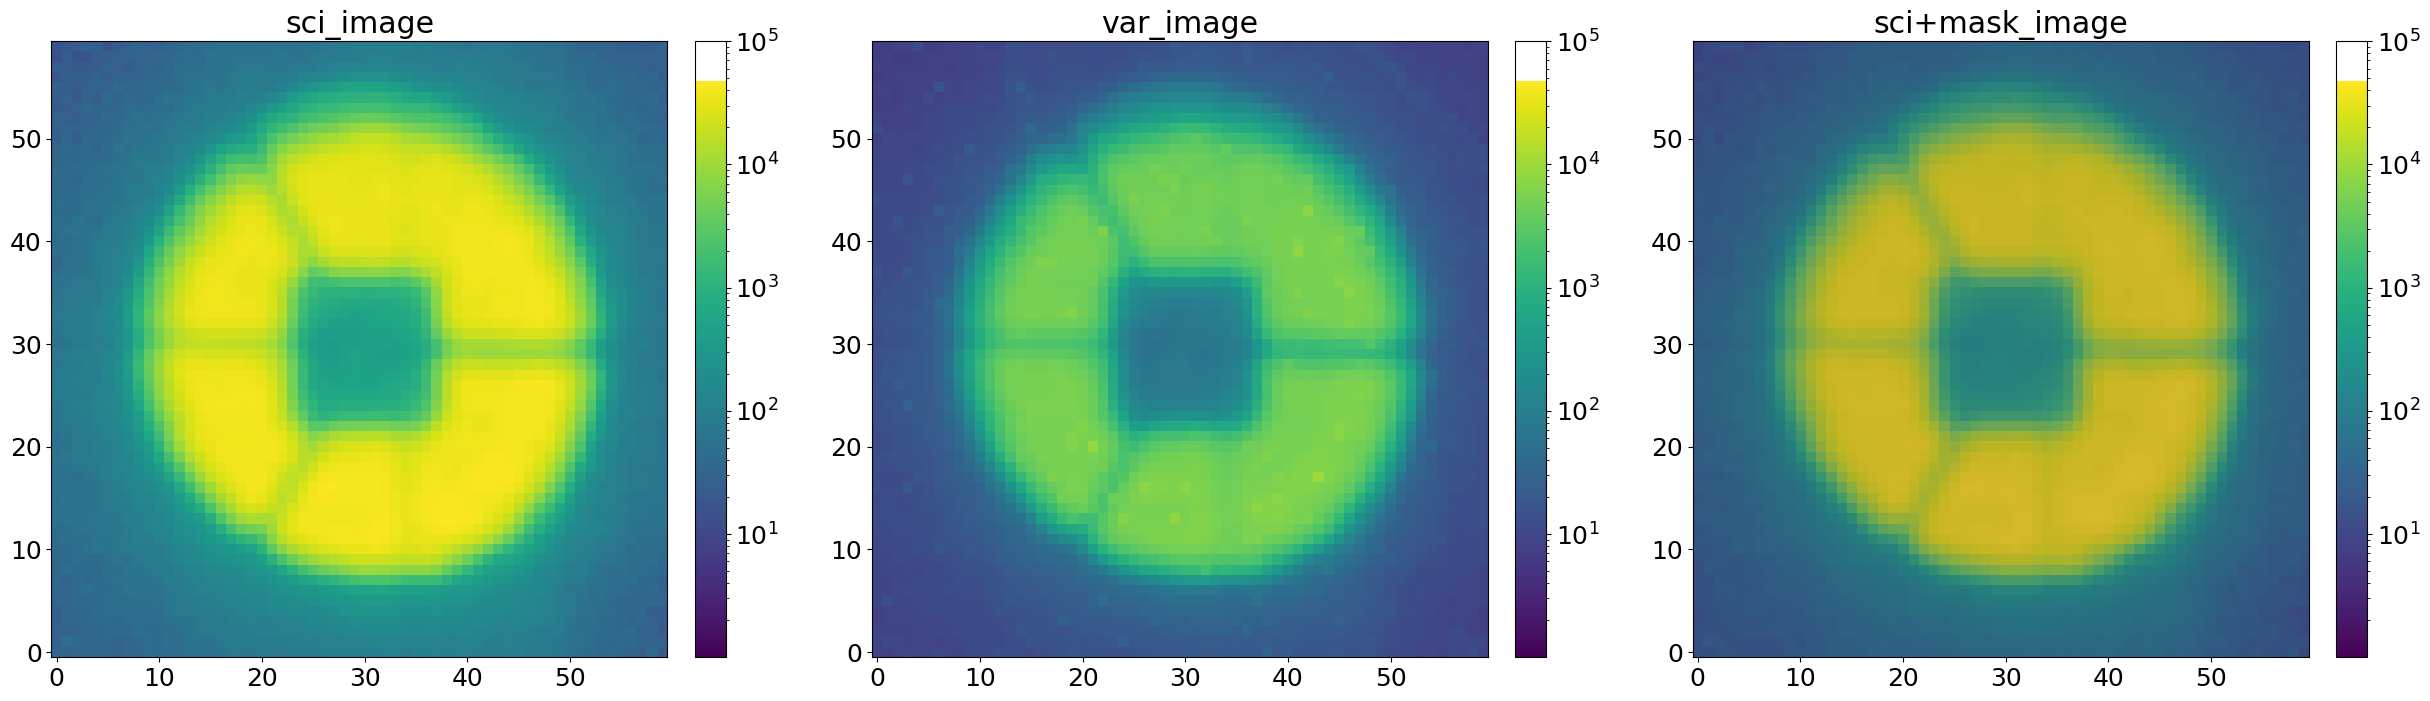

In [14]:
single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_short_with_focus)


# lets use the simplest function of the class - that creates the basic image
# showing science, variance and mask image (overlayed over sci image)
# mask image is almost always empty so it will just show like a darker
# sci image
# This function will show the image specified in `obs`, i.e., m4 image 
# in this case
single_analysis.create_basic_data_image()

In [19]:
# Let's look at some of the properties contained in the class

# Is the source the double source, and if yes how strong is the
# secondary source
double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
# list contaning science, variance and mask images
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
# what is the index of `obs`` image (m4 in this example)
# in list_of_defocuses (['m4','0','p4'])
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
# names of columns for different parameters we have passed - we will 
# elaborate on various columns later
columns,columns22,columns22_analysis=single_analysis.return_columns()

# These functions below take the raw output of the fitting procedure and 
# create:
# minchain_parametrization - best fitting parameters
# and like_min - `minimal likelihood``, i.e., parameter describing the 
# quality of the fit.
# Unfortunately `like_min` is not really minimal likelihood. The name is a
# relic from the past when at one point the quantity calculated was
# likelihood. 
#
# chain0_swarm_1 contains information about movement of all particles
# and likechain0_swarm_1 contains information about the quality of the fit
# at step of the procedure
chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
len_of_chains=single_analysis.len_of_chains()
minchain_parametrization,like_min=single_analysis.create_likelihood()

create_chains_swarm_1: Swarm1 and likechainSwarm1 found
Path searched was: /tigress/ncaplar/Results/chainMar2522_Single_P_34437536ArSwarm1.npy
create_chains_swarm_1: Swarm1 and likechainSwarm1 found
Path searched was: /tigress/ncaplar/Results/chainMar2522_Single_P_34437536ArSwarm1.npy
(36, 480, 61)
minimal likelihood is: 16.830976617368595


In [20]:
index_of_single_image


0